In [1]:
from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
ROW_NAME_AVG = 'AVG'
ROW_NAME_STD = 'STD'

def gen_df(benchmark, header_col):
    FILE_PATH = '../../playbooks/remote_read_' + benchmark + '/output/result.csv'

    with open(FILE_PATH, 'r') as f:
        num_rows = f.readline().count(',')
    df = pd.read_csv(FILE_PATH, index_col=header_col, header=None,
                     names=range(1, num_rows - len(header_col) + 2)).T

    
    # Add the avrerage row and the standard deviation row 
    df = df.rename({num_rows - len(header_col) + 1: ROW_NAME_AVG})
    df.loc[ROW_NAME_STD] = np.nan

    num_data_raws = num_rows - len(header_col)
    for category in df.columns:
        df[category][ROW_NAME_AVG] = np.mean(df[category][:num_data_raws])
        df[category][ROW_NAME_STD] = np.std(df[category][:num_data_raws], ddof=1)

    display(HTML(df.to_html()))
    
    return df

In [3]:
def show_chart(benchmark):
    df = gen_df(benchmark, [0, 1, 2])

    # Start to draw the chart
    
    N = len({c[0] for c in df.columns})
    ind = np.arange(N)  # the x locations for the groups

    # Draw bins for Cycles
    fig, ax1 = plt.subplots()
    
    num_servs = len({c[1] for c in df.columns})
    bar_width = 1 / (num_servs + 2)
    
    cycle_bars = []
    for s in range(num_servs):
        bar = ax1.bar(ind + s / (num_servs + 2),
                            df.loc[ROW_NAME_AVG][2 * s::2 * num_servs],
                            width=bar_width,
                            yerr=df.loc[ROW_NAME_STD][2 * s::2 * num_servs])
        cycle_bars.append(bar)

    ax1.set_yscale('log')
    ax1.set_ylim(ymin=1e8)
    
    ax1_clr = 'r'
    ax1.set_ylabel(df.columns[0][2], color=ax1_clr)
    ax1.tick_params('y', colors=ax1_clr)


    # Draw lines for Bitrate
    ax2 = ax1.twinx()

    bitrate_bars = []
    for s in range(num_servs):
        bar = ax2.errorbar(ind,
                           df.loc[ROW_NAME_AVG][2 * s + 1::2 * num_servs],
                           yerr=df.loc[ROW_NAME_STD][2 * s + 1::2 * num_servs],
                           fmt='-o')
        bitrate_bars.append(bar)

    ax2_clr = 'b'
    ax2.set_ylabel(df.columns[1][2] + ' (bit/s)', color=ax2_clr)
    ax2.tick_params('y', colors=ax2_clr)

    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(120)

    ax1.set_xlabel('Transmission Size (Bytes)')

    labels = [c[0] for c in df.columns][0::2 * num_servs]
    plt.xticks(ind + bar_width, labels)
    
    type_legend = plt.legend([cycle_bars[0], bitrate_bars[0]],
                             [df.columns[0][2], df.columns[1][2]],
                            loc=2)
    plt.gca().add_artist(type_legend)
    ax1.legend(cycle_bars,
           [str(n) + ' servers' for n in range(1, num_servs + 1)],
           ncol=3,
           loc=8,
           bbox_to_anchor=(0.5, -0.4))
    
    
    plt.title('CPU Cycles and Network Bandwidth on Client under Different Transmission Size \n(' + benchmark + ')', y=1.1)
    
    plt.savefig('../charts/remote_read_cycles_' + benchmark + '.png', bbox_inches='tight')
    plt.show()

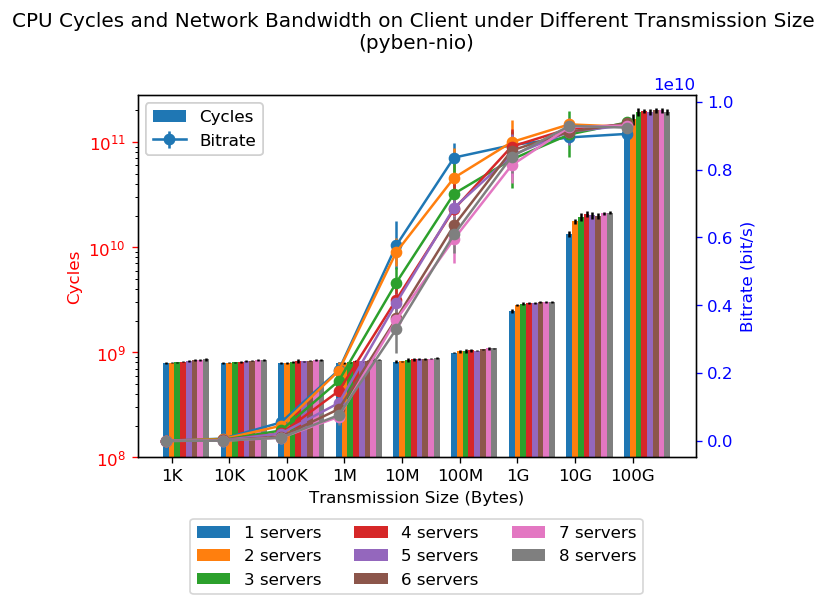

In [4]:
show_chart('pyben-nio')